# Tech Challenge - Fase 4 (Data viz and production models)
**Integrantes do grupo 43**
- Gabriel Tomaz
- Pedro Costa
- Thiago Aragão

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Web Scraping
Como o site Ipeadata não oferece a opção de download, foi criada a rotina abaixo para realizar web scraping e exportar os dados para um arquivo CSV.

## Instalação/Importação das bibliotecas necessárias para o web scraping

- pandas: Usado para manipulação e estruturação de dados, incluindo a criação e exportação de arquivos CSV.
- requests: Utilizado para fazer requisições HTTP e obter o conteúdo das páginas web.
- beautifulsoup4: Ferramenta para extrair e analisar dados de páginas HTML de forma estruturada.

In [5]:
!pip install pandas
!pip install requests
!pip install beautifulsoup4

import requests
import pandas as pd
from bs4 import BeautifulSoup

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Rotina para fazer o web scraping

O código abaixo acessa a URL do Ipeadata, faz uma requisição HTTP para obter o conteúdo da página e usa o BeautifulSoup para transformar o HTML em um formato estruturado para análise.

In [6]:
url = "http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view"
response = requests.get(url) 
html = BeautifulSoup(response.content, "html.parser") 

Com o HTML da página estruturado, é possível localizar a tabela que contém os dados. Ao analisar o HTML do site, percebe-se que cada linha da tabela possui um ID que começa com "grd_DXMainTable" seguido do índice do registro (1, 2, 3...). O código abaixo filtra apenas esses itens e retorna uma lista de elementos.

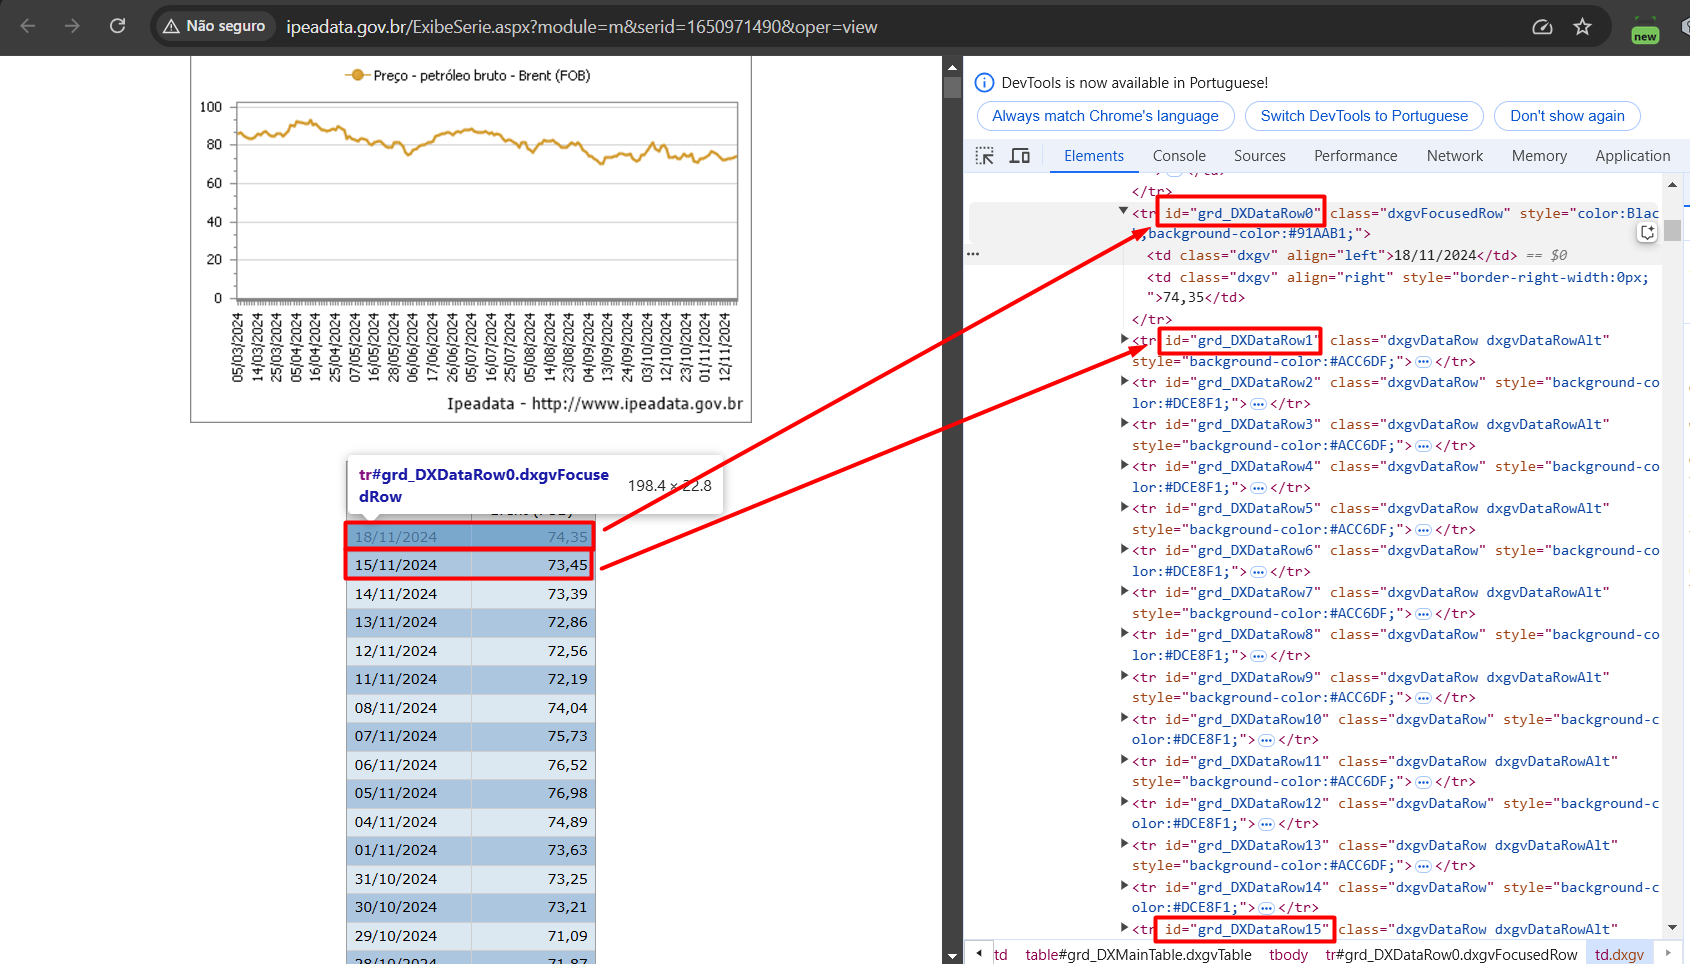

In [7]:
elementos = html.find(id = "grd_DXMainTable")
elementos = elementos.find_all(lambda tag: tag.get('id') and 'grd_DXDataRow' in tag['id'])

Com a lista de elementos contendo as informações necessárias, é possível percorrer cada item para extrair a data e o valor, armazenando-os em um array.

In [8]:
dados = [] 

for row in elementos[1:]: 
	cols = row.find_all("td") 
	dados.append([col.text.strip() for col in cols]) 

O código abaixo cria um DataFrame com as colunas "Data" e "Valor", usando os dados extraídos do site. Ajusta a data para o formato ano-mês-dia e converte o valor de string para float. Depois, o DataFrame é exportado em um arquivo CSV.

In [9]:
df = pd.DataFrame(dados, columns=["Data", "Valor"]) 
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
df['Valor'] = df['Valor'].str.replace(',', '.').astype(float)

nome_do_arquivo = 'preco_por_barril_do_petroleo.csv'
df.to_csv(nome_do_arquivo, index=False, sep=';')

# Analise da base de dados

No código abaixo, são executados os seguintes passos:
- O arquivo CSV é importado para o pandas; 
- A coluna "Data" é definida como índice do DataFrame; 
- Ordenação dos dados pelo índice;
- Apresentação dos 5 primeiros registros;

In [10]:
df = pd.read_csv(nome_do_arquivo, sep=";" , parse_dates=['Data'], index_col='Data')
df = df.sort_index()
df.head()

,Valor
Data,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


No código abaixo, verifica-se se existe algum valor nulo no DataFrame e são exibidas as estatísticas básicas, nas quais é possível conferir o menor e o maior valor do barril de petróleo.

In [11]:
print(df.isnull().sum())

print("\n\nEstatísticas básicas\n")
print(df.describe())

Valor    0
dtype: int64


Estatísticas básicas

              Valor
count  11306.000000
mean      53.338089
std       33.152480
min        9.100000
25%       20.630000
50%       48.950000
75%       76.770000
max      143.950000


# Modelos de Machine Learning

No código abaixo, o DataFrame é preparado para ser usado nos modelos. Primeiro, o índice é resetado para que a data se torne uma coluna. Em seguida, os nomes das colunas são alterados: "data" é renomeada para "ds" e "valor" para "y".

In [35]:
df_novo = df.sort_index().reset_index()
df_novo = df_novo.rename(columns={'Data':'ds','Valor':'y'})

No código abaixo, são extraídas as datas de início e fim que serão usadas para solicitar a previsão aos modelos. Neste caso, a previsão será feita para um período de 7 dias.

In [13]:
from datetime import timedelta

data_fim = df_novo.iloc[-1]['ds']
data_inicio = data_fim - timedelta(days=7)

data_fim_str = data_fim.strftime('%Y-%m-%d')
data_inicio_str = data_inicio.strftime('%Y-%m-%d')

Neste ponto, o DataFrame é dividido em conjuntos de treino e teste com base nas datas extraídas anteriormente.

In [14]:
treino = df_novo.loc[df_novo['ds'] < data_inicio_str]
teste = df_novo.loc[(df_novo['ds'] >= data_inicio_str) & (df_novo['ds'] <= data_fim_str)]

## Funções para calcular e apresentar as metricas de avaliação dos modelos

- **mean_absolute_error (MAE):** Calcula a média das diferenças absolutas entre os valores previstos e os valores reais. Mede o erro médio em unidades da variável de previsão.

- **mean_squared_error (MSE):** Calcula a média dos quadrados das diferenças entre os valores previstos e os valores reais. Penaliza erros maiores mais fortemente do que o MAE, e é sensível a outliers.

- **mean_absolute_percentage_error (MAPE):** Mede o erro médio percentual entre os valores previstos e os valores reais. Expressa o erro como uma porcentagem, facilitando a comparação de desempenho em diferentes escalas.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def calculate_metrics(y_true, y_pred):
    mae = round(mean_absolute_error(y_true, y_pred), 2)
    mse = round(mean_squared_error(y_true, y_pred), 2)
    mape = round(mean_absolute_percentage_error(y_true, y_pred) * 100, 2)
    return mae, mse, mape

In [ ]:
def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}")

## Função para exibir o gráfico de forma clara e organizada

In [37]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

def apresentar_grafico(titulo, coluna_data, coluna_valor, coluna_valor_previsao):
    fig, ax = plt.subplots(figsize=(15, 8))

    ax.plot(coluna_data, coluna_valor, marker='o', label='Ultimo')
    ax.plot(coluna_data, coluna_valor_previsao, marker='o', label='Previsão')

    ax.legend()
    ax.set_xlabel('DATA')
    ax.set_ylabel('PREÇO')
    ax.set_title(titulo)
    ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

    # Configuração eixo X
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

    # Configuração eixo Y
    y_menor = coluna_valor.min()
    y_maior = coluna_valor.max()

    if(y_menor > coluna_valor_previsao.min()):
        y_menor = coluna_valor_previsao.min()

    if(y_maior < coluna_valor_previsao.max()):
        y_maior = coluna_valor_previsao.max()
    
    ax.set_ylim(y_menor - 1, y_maior + 1)

    plt.xticks(rotation=25)
    plt.show()

## Modelo ARIMA

O comando abaixo realiza a instalação da biblioteca Statsmodels, que é utilizada para análise estatística, econometria e modelagem de séries temporais.

In [17]:
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable


O código abaixo realizará o treinamento com o modelo ARIMA e identificará os melhores parâmetros (p, d e q) para ajustar o ARIMA aos dados disponíveis.

In [18]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Testando diferentes combinações de p, d, q
melhor_aic = np.inf
melhor_order = None

p = 1  # ordem da parte autorregressiva
d = 1  # número de diferenciações
q = 1  # ordem da média móvel

for p in range(0, 3):
    for d in range(0, 2):
        for q in range(0, 3):
            try:
                arima_model = ARIMA(treino['y'], order=(p, d, q))
                arima_model_fit = arima_model.fit()
                aic = arima_model_fit.aic
                if aic < melhor_aic:
                    melhor_aic = aic
                    melhor_order = (p, d, q)
            except:
                continue

p = melhor_order[0]
d = melhor_order[1]
q = melhor_order[2]

print(f'Melhores parâmetros: p={p}, d={d}, q={q}')

Melhores parâmetros: p=2, d=1, q=2


Treinando o ARIMA com a base de dados de treino e os melhores parâmetros

In [19]:
arima_model = ARIMA(treino['y'], order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_forecast = arima_model_fit.forecast(steps=len(teste))

print(arima_forecast)

11300    73.086767
11301    73.008056
11302    73.131351
11303    73.196873
11304    73.154558
11305    73.114082
Name: predicted_mean, dtype: float64


Metricas do ARIMA

In [20]:
metrics_arima = calculate_metrics(teste['y'], arima_forecast)
print("Metricas ARIMA:")
print_metrics(metrics_arima)

Metricas ARIMA:
MAE: 1.49
MSE: 2.88
MAPE: 1.99


Gráfico apresentando os valores reais e o previsto pelo modelo ARIMA

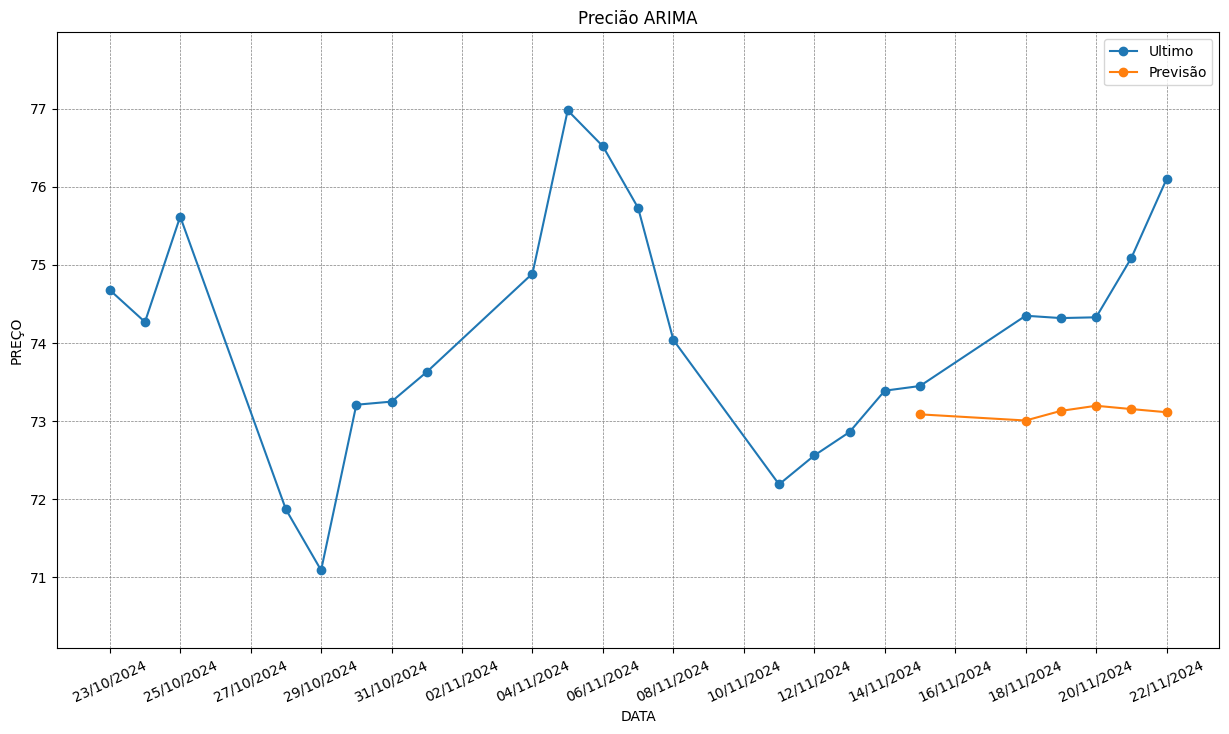

In [40]:
data_inicio_garfico = (df_novo.iloc[-1]['ds'] - timedelta(days=30)).strftime('%Y-%m-%d')
data_inicio_str = data_inicio.strftime('%Y-%m-%d')

data = pd.date_range(start= teste['ds'].min(), end=teste['ds'].max(), freq='B')
arima_forecast_df = pd.DataFrame({'ds': data, 'previsao': arima_forecast})
arima_forecast_df = df_novo.loc[df_novo['ds'] >= data_inicio_garfico].merge(arima_forecast_df, how='left')

apresentar_grafico('Precião ARIMA', arima_forecast_df['ds'], arima_forecast_df['y'], arima_forecast_df['previsao'])

## Modelo Prophet

O comando abaixo realiza a instalação da biblioteca Prophet, que é usada para modelagem e previsão de séries temporais.

In [28]:
!pip install Prophet

Defaulting to user installation because normal site-packages is not writeable


O código usa o modelo Prophet para fazer previsões de séries temporais. Ele treina o modelo com dados de treino e gera previsões para um intervalo de datas do conjunto de teste. Por fim, exibe as primeiras previsões feitas pelo modelo.

In [ ]:
from prophet import Prophet

modelo_prophet = Prophet(daily_seasonality=True)
modelo_prophet.fit(treino)

prever = pd.date_range(start=teste['ds'].min(), end=teste['ds'].max(), freq='B')
prever = pd.DataFrame({ 'ds': prever })
previsao = modelo_prophet.predict(prever)
previsao.head()

21:23:25 - cmdstanpy - INFO - Chain [1] start processing
21:23:33 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-11-15,91.099333,73.313011,100.879007,91.099333,91.099333,-2.875606,-2.875606,-2.875606,-1.527793,...,0.017751,0.017751,0.017751,-1.365565,-1.365565,-1.365565,0.0,0.0,0.0,88.223727
1,2024-11-18,91.139284,75.008483,101.941052,91.139284,91.139284,-2.975812,-2.975812,-2.975812,-1.527793,...,0.040162,0.040162,0.040162,-1.488180,-1.488180,-1.488180,0.0,0.0,0.0,88.163472
2,2024-11-19,91.152600,74.950334,101.340144,91.152600,91.152600,-3.102627,-3.102627,-3.102627,-1.527793,...,-0.043803,-0.043803,-0.043803,-1.531031,-1.531031,-1.531031,0.0,0.0,0.0,88.049974
3,2024-11-20,91.165917,74.492756,100.622655,91.165917,91.165917,-3.191510,-3.191510,-3.191510,-1.527793,...,-0.088426,-0.088426,-0.088426,-1.575290,-1.575290,-1.575290,0.0,0.0,0.0,87.974408
4,2024-11-21,91.179234,73.657188,101.790916,91.179234,91.179234,-3.143289,-3.143289,-3.143289,-1.527793,...,0.005631,0.005631,0.005631,-1.621127,-1.621127,-1.621127,0.0,0.0,0.0,88.035945


Metricas do Prophet

In [32]:
metrics_prophet = calculate_metrics(teste['y'], previsao['yhat'])

print("Metricas Prophet:")
print_metrics(metrics_prophet)

Metricas Prophet:
MAE: 13.47
MSE: 182.22
MAPE: 18.07


Gráfico apresentando os valores reais e o previsto pelo modelo Prophet

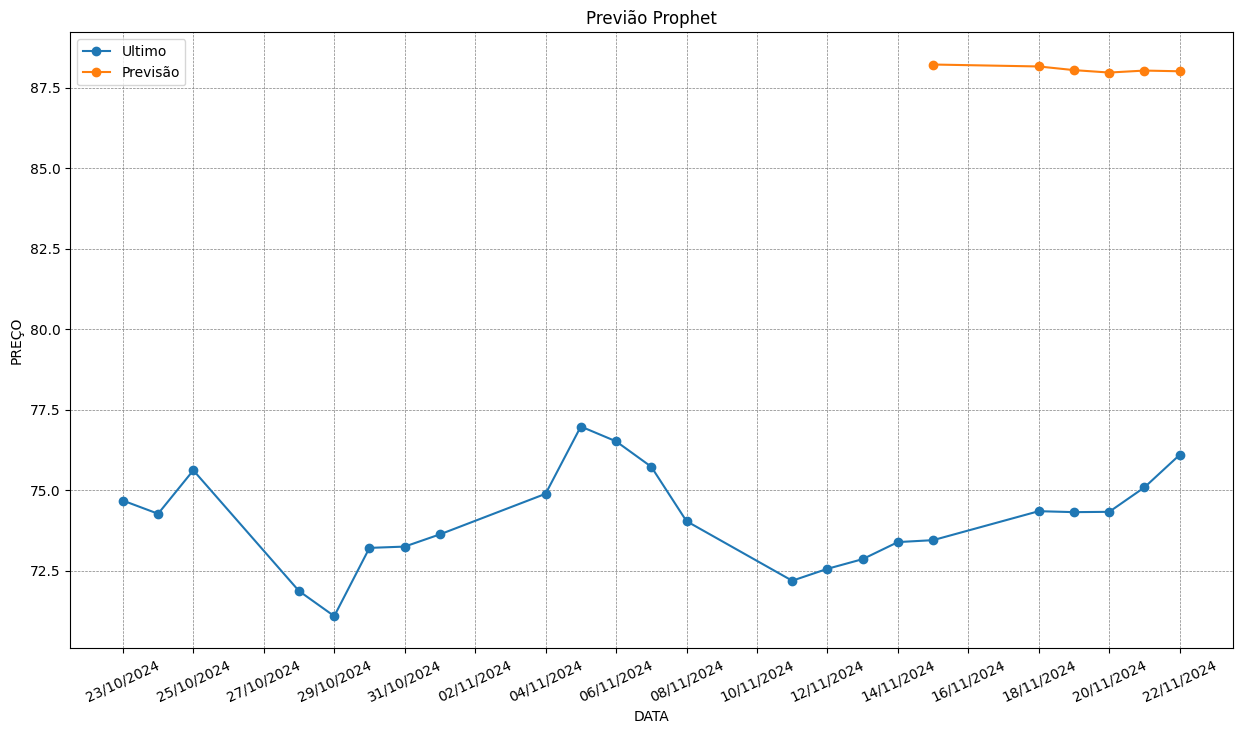

In [44]:
prophet_forecast_df = df_novo.loc[df_novo['ds'] >= data_inicio_garfico].merge(previsao, how='left')
prophet_forecast_df[['ds', 'y', 'yhat']].tail()

apresentar_grafico('Previão Prophet', prophet_forecast_df['ds'], prophet_forecast_df['y'], prophet_forecast_df['yhat'])

# Tabela com as métricas dos modelos

- **MAE (Erro Absoluto Médio):** Média dos erros absolutos entre previsões e valores reais. Menor MAE indica previsões mais precisas.
- **MSE (Erro Quadrático Médio):** Média dos erros quadrados entre previsões e valores reais. Penaliza mais erros grandes; menor MSE indica melhor acurácia.
- **MAPE (Erro Percentual Absoluto Médio):** Média dos erros percentuais absolutos. Expressa o erro como uma porcentagem dos valores reais; menor MAPE indica previsões mais próximas dos valores reais.

In [45]:
mae_arima, mse_arima, mape_arima = metrics_arima
mae_prophet, mse_prophet, mape_prophet = metrics_prophet

df_metricas = pd.DataFrame({
    'Modelo': ['Prophet', 'ARIMA'],
    'MAE': [mae_prophet, mae_arima],
    'MSE': [mse_prophet, mse_arima],
    'MAPE': [mape_prophet, mape_arima]
})

df_metricas.head()

,Modelo,MAE,MSE,MAPE
0,Prophet,13.47,182.22,18.07
1,ARIMA,1.49,2.88,1.99


O modelo ARIMA apresentou melhores resultados em comparação ao Prophet, com valores significativamente menores de MAE (1.49), MSE (2.88) e MAPE (1.99), indicando maior precisão nas previsões.